### <strong>第四次作品：卷積神經網路 CNN 在影像辨識與超解析生成的練習 - 2</strong>
學號：711233112

姓名：留筠雅
<hr>

 <font color=skyblue>作品目標</font>：  
 本作品旨在使用 PyTorch 實現 SRCNN（Super-Resolution Convolutional Neural Network）模型，進行高解析度影像生成的訓練與測試。相較於課堂提供的範例程式碼，本作品將進行以下改變與增強：

- 使用 pre-trained 模型進行進一步訓練，導入預先訓練的 .pth 模型權重，並進行額外的訓練。
- 增加訓練與測試的次數，並分別記錄 Train PSNR 與 Val PSNR 值，以評估模型訓練的效果。
- 測試不同的測試集評估在 Set5 與 Set14 測試集上的 PSNR（Peak Signal-to-Noise Ratio），以確定模型在不同場景下的性能表現。
- 實際應用於影像放大，編寫程式將任意選擇的影像，使用已訓練的模型進行2倍高解析度影像生成，並與 Bicubic 方法的結果進行對比，以展示 SRCNN 的實際效果。

期望達成的成果：

- 通過進一步的訓練提升模型的重建能力，以提高訓練後的 PSNR 值。
- 在測試集上展示模型的泛化能力，確保其在真實世界中的應用效果。
- 提供一個實用的影像放大解決方案，顯示 SRCNN 相對於傳統方法（如 Bicubic）的優勢。
 
 


<hr>

附上CNN模型，不同之處在於
1. 增加了卷基層裡的通道數並更改 kernel 與 padding 大小。 使得模型的總參數和可訓練參數的數量增加，目的是希望訓練效果會比課堂上的原始SRCNN模型來的好，但可能會導致模型訓練時間拉長。
   
2. TRAIN_BATCH_SIZE 改成 64，表示每次訓練模型時將從訓練集加載 64 張圖像進行一次前向和反向傳播。


In [14]:
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        
        
        self.conv1 = nn.Conv2d(
            3, 128, kernel_size=9, stride=(1, 1), padding=(4, 4)
        )
        self.conv2 = nn.Conv2d(
            128, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)
        )
        self.conv3 = nn.Conv2d(
            64, 3, kernel_size=5, stride=(1, 1), padding=(2, 2)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x

if __name__ == '__main__':
    model = SRCNN()
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")


109,827 total parameters.
109,827 training parameters.


In [15]:

import torch
import numpy as np
import glob as glob

from torch.utils.data import DataLoader, Dataset
from PIL import Image

TRAIN_BATCH_SIZE = 64 #改過成64 原128
TEST_BATCH_SIZE = 1

# The SRCNN dataset module.
class SRCNNDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")
        self.all_label_paths = glob.glob(f"{label_paths}/*") 

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        image = Image.open(self.all_image_paths[index]).convert('RGB')
        label = Image.open(self.all_label_paths[index]).convert('RGB')

        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)

        image /= 255.
        label /= 255.

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])

        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

# Prepare the datasets.
def get_datasets(
    train_image_paths, train_label_paths,
    valid_image_path, valid_label_paths
):
    dataset_train = SRCNNDataset(
        train_image_paths, train_label_paths
    )
    dataset_valid = SRCNNDataset(
        valid_image_path, valid_label_paths
    )
    return dataset_train, dataset_valid

# Prepare the data loaders
def get_dataloaders(dataset_train, dataset_valid):
    train_loader = DataLoader(
        dataset_train, 
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True
    )
    valid_loader = DataLoader(
        dataset_valid, 
        batch_size=TEST_BATCH_SIZE,
        shuffle=False
    )
    return train_loader, valid_loader
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

from torchvision.utils import save_image

plt.style.use('ggplot')

def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition

    Note that the output and label pixels (when dealing with images) should
    be normalized as the `max_val` here is 1 and not 255.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    diff = outputs - label
    rmse = math.sqrt(np.mean((diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

def save_plot(train_loss, val_loss, train_psnr, val_psnr):
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/outputs/loss.png')
    plt.close()

    # PSNR plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_psnr, color='green', label='train PSNR dB')
    plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.savefig('C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/outputs/psnr.png')
    plt.close()

def save_model_state(model):
    # save the model to disk
    print('Saving model...')
    torch.save(model.state_dict(), 'C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/outputs/model.pth')

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    # Remove the last model checkpoint if present.
    torch.save({
                'epoch': epochs+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/outputs/model_ckpt.pth")

def save_validation_results(outputs, epoch, batch_iter):
    """
    Function to save the validation reconstructed images.
    """
    save_image(
        outputs, 
        f"C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/outputs/valid_results/val_sr_{epoch}_{batch_iter}.png"
    )

讀入 pre-trained 的 pth 檔，再進行 2 次 training，並展示其  Train PSNR 與 Val PSNR 值。

模型所訓練的資料集來自 T91 資料集，測試資料是 Set5 與 Set14，所有的低解析圖像來自Bicubic 插值 2倍倍率。

In [16]:
import torch
import time
import torch.optim as optim
import torch.nn as nn
import os
import argparse
from tqdm import tqdm

# Learning parameters.
epochs = 2 # Number of epochs to train the SRCNN model for.
lr = 0.001 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # Constants
TRAIN_LABEL_PATHS = 'C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/input/t91_hr_patches'
TRAN_IMAGE_PATHS = 'C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/input/t91_lr_patches'
VALID_LABEL_PATHS = 'C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/input/test_hr'
VALID_IMAGE_PATHS = 'C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/input/test_bicubic_rgb_2x'
SAVE_VALIDATION_RESULTS = True

os.makedirs('C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/outputs/valid_results', exist_ok=True)

# Initialize the model.
print('Computation device: ', device)
model =SRCNN().to(device)
checkpoint = torch.load(
    "C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/outputs/model_ckpt.pth")
model.load_state_dict(checkpoint['model_state_dict'])

print(model)

# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function. 
criterion = nn.MSELoss()

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_valid)}")

def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # Zero grad the optimizer.
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)

        # Backpropagation.
        loss.backward()
        # Update the parameters.
        optimizer.step()

        # Add loss of each item (total items in a batch = batch size).
        running_loss += loss.item()
        # Calculate batch psnr (once every `batch_size` iterations).
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr


def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            
            outputs = model(image_data)
            loss = criterion(outputs, label)

            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr

            # For saving the batch samples for the validation results
            # every 100 epochs.
            if SAVE_VALIDATION_RESULTS and (epoch % 100) == 0:
                save_validation_results(outputs, epoch, bi)

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr = validate(model, valid_loader, epoch+1)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training.
    if (epoch+1) % 100 == 0:
        save_model(epoch, model, optimizer, criterion)
    # Save the model state dictionary only every epoch. Small size, 
    # can be used for inference.
    save_model_state(model)
    # Save the PSNR and loss plots every epoch.
    save_plot(train_loss, val_loss, train_psnr, val_psnr)

end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Computation device:  cuda
SRCNN(
  (conv1): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)
Training samples: 22227
Validation samples: 19
Epoch 1 of 2


100%|██████████| 19/19 [00:01<00:00, 16.07it/s]


Train PSNR: 30.629
Val PSNR: 29.757
Saving model...
Epoch 2 of 2


100%|██████████| 19/19 [00:01<00:00, 18.57it/s]


Train PSNR: 30.969
Val PSNR: 29.727
Saving model...
Finished training in: 1.447 minutes


觀察討論：

PSNR是在像素值重建方面常用的指標，特別是在圖像重建如超解析中。較高的PSNR值表示重建圖像與原始圖像之間的差異較小，重建品質較高。
一般來說，PSNR的數值可以按照以下指南進行大致評估：

20以下：非常低的PSNR，表示重建的影像與原始影像有很大的差異，品質非常差。

20到25之間：低PSNR，影像品質仍然較差，可能出現明顯的視覺失真。

25到30之間：中等PSNR，表示影像重建的品質已經較為接近原始影像，但仍有些微的視覺差異。

30到35之間：較高的PSNR，影像品質良好，視覺上的差異已經很難察覺。

35以上：非常高的PSNR，重建的影像與原始影像非常接近，視覺上幾乎無法區分。

訓練集的低解析影像是由原始影像的小區塊經過縮小後再經由雙三次插值放大而生成的。具體來說，影像的每個小區塊（patch）被縮小為原來的一半大小，然後再使用雙三次插值方法放大回原始大小，因此會模糊2倍。然而此模型的訓練與測試結果PSNR都接近30，表示訓練效果良好。


測試 Set5 與 Set14 並展示 Test PSNR on Set5 與 Test PSNR on Set14。

In [20]:
import torch
import glob as glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            outputs = model(image_data)
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr


# The SRCNN dataset module.
class SRCNNDataset(Dataset):
    def __init__(self, image_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        # The high resolution ground truth label.
        label = Image.open(self.all_image_paths[index]).convert('RGB')
        w, h = label.size[:]
        # Convert to 2x bicubic.
        low_res_img = label.resize((int(w*0.5), int(h*0.5)), Image.BICUBIC)
        # The low resolution input image.
        image = low_res_img.resize((w, h), Image.BICUBIC)

        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)

        image /= 255.
        label /= 255.

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])

        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

# Prepare the datasets.
def get_datasets(
    image_paths
):
    dataset_test = SRCNNDataset(image_paths)
    return dataset_test

# Prepare the data loaders
def get_dataloaders(dataset_test):
    test_loader = DataLoader(
        dataset_test, 
        batch_size=1,
        shuffle=False
    )
    return test_loader


if __name__ == '__main__':
    # Load the model.
    model = SRCNN().to(device)
    model.load_state_dict(
        torch.load('C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/outputs/model.pth'))

    data_paths = [
        ['C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/input/Set5/LRbicx2', 'Set5'],
        ['C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/input/Set14/LRbicx2', 'Set14']
    ]

    for data_path in data_paths:
        dataset_test = get_datasets(data_path[0])
        test_loader = get_dataloaders(dataset_test)

        _, test_psnr = validate(model, test_loader, device)
        print(f"Test PSNR on {data_path[1]}: {test_psnr:.3f}")

100%|██████████| 5/5 [00:00<00:00, 19.84it/s]


Test PSNR on Set5: 29.788


100%|██████████| 14/14 [00:00<00:00, 26.97it/s]

Test PSNR on Set14: 27.924


觀察討論：
- 在 Set5 數據集上的平均 PSNR 為 29.788。
- 在 Set14 數據集上的平均 PSNR 為 27.924。
這些數字顯示了在這兩個測試集上，經過模型預測和計算後，得到同一資料集下的平均 PSNR 值。根據結果，Set5 數據集的表現稍微優於 Set14 數據集。

對已訓練完成的 CNN 模型，輸入任何挑選的影像，將之放大 2 倍之高解度影像，並觀察圖像品質。
- 這四張圖片由左至右依序代表：
  1. 原始圖像
  2. Bicubic 插值2倍倍率
  3. 使用自己調整的 CNN 模型輸出圖像
  4. 使用課堂上下載的 CNN 模型輸出圖像
- 無論是調整後的 CNN 模型或是原始 CNN 模型，皆已同樣次數訓練(Epochs = 500)

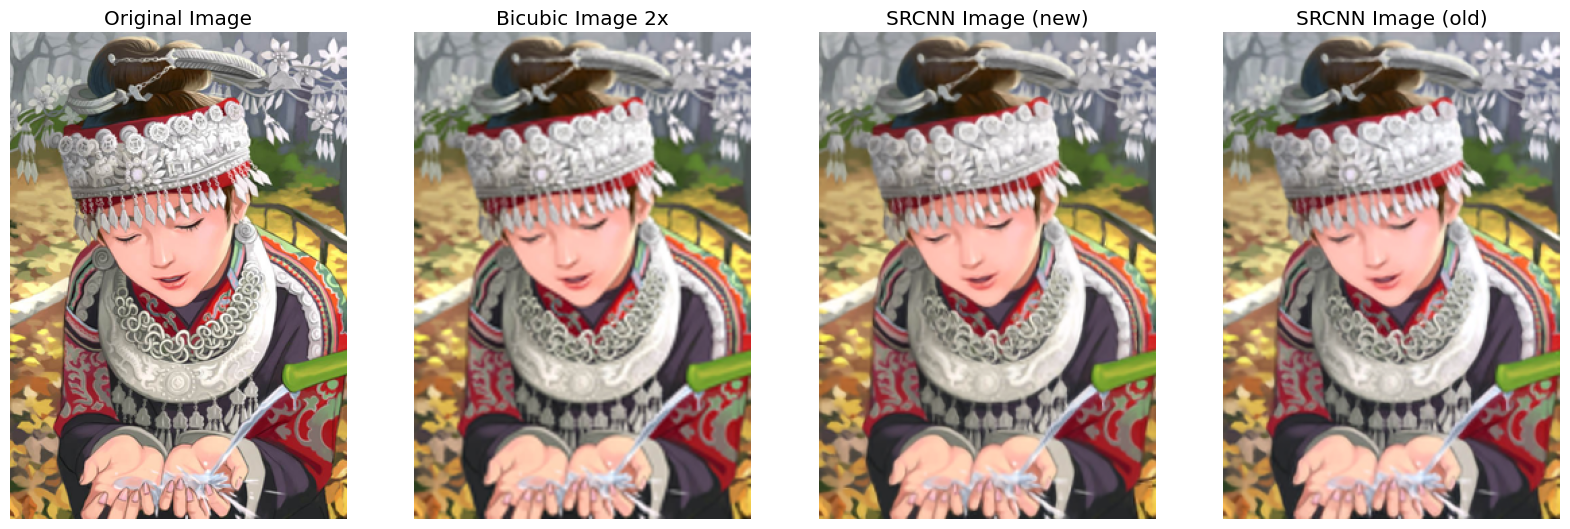

PSNR of Original Image and Bicubic Image: 24.599
PSNR of Original Image 2x and SRCNN Image(new): 24.992
PSNR of Original Image 2x and SRCNN Image(old): 24.765


In [22]:
import matplotlib.pyplot as plt

img1 = plt.imread('C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/input/test_hr/comic.png')
img2 = plt.imread('C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/input/test_bicubic_rgb_2x/comic.png')
img3 = plt.imread('C:/Users/f9006/Downloads\
/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/outputs/valid_results/val_sr_500_7.png')
img4 = plt.imread('D:/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\
/outputs/valid_results/val_sr_500_7.png')

psnr1 = psnr(torch.tensor(img1), torch.tensor(img2))
psnr2 = psnr(torch.tensor(img1), torch.tensor(img3))
psnr3 = psnr(torch.tensor(img1), torch.tensor(img4))

fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(img1)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(img2)
ax[1].set_title('Bicubic Image 2x')
ax[1].axis('off')
ax[2].imshow(img3)
ax[2].set_title('SRCNN Image (new)')
ax[2].axis('off')
ax[3].imshow(img4)
ax[3].set_title('SRCNN Image (old)')
ax[3].axis('off')

plt.show()
print(f"PSNR of Original Image and Bicubic Image: {psnr1:.3f}")
print(f"PSNR of Original Image 2x and SRCNN Image(new): {psnr2:.3f}")
print(f"PSNR of Original Image 2x and SRCNN Image(old): {psnr3:.3f}")

觀察討論：

- 以肉眼觀察確實 SRCNN 有達到重建圖像的味道，可以看到圖片中女性的睫毛還有臉上與手上的輪廓線條，都有比低解析圖像清晰。
- 根據 PSNR值可以看到 SRCNN 無論哪個模型都比低解析圖像高，符合圖像的觀察結論。
- 根據前面的設定增加通道數和核大小，會提高重建圖像的清晰程度，但特徵參數增加會增加運算時間。